# Load libraries

In [13]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier

# Read train and test data

In [16]:
dfXtrain = pd.read_csv('X.train.csv')
dfXtest = pd.read_csv('X.test.csv')
dfYtrain = pd.read_csv('y.train.csv')
Xtrain = np.array(dfXtrain)
Xtest = np.array(dfXtest)

ytrain = np.array(dfYtrain['label'])

In [17]:
print('Data size:', dfXtrain.shape)
dfXtrain.head()

Data size: (4099, 1330)


,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V1322,V1323,V1324,V1325,V1326,V1327,V1328,V1329,V1330,V1331
0,826.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,NaN,0.0,0.5
1,15.0,0.0,0,0.0,0.0,0.0,0.0,0.030303,0.083333,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0
2,242.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,1.0,1.0,0.0,0.5,0.0,0.0,1.0,0.0,0.0,0.5
3,1038.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
4,971.0,0.0,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,0.0,0.0,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0


# Replace all NaN's in train and test data to most frequent values in train data

In [18]:
Xbig = np.vstack((Xtrain, Xtest))

In [19]:
imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
imp.fit(Xbig)

Xtrain = imp.transform(Xtrain)
Xtest = imp.transform(Xtest)

# Train Random Forest classifier

In [29]:
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(Xtrain, ytrain, test_size=0.5)

In [21]:
from sklearn.metrics import log_loss

In [22]:
def get_score_list(X, y, clf):
    predictions = list()
    score = list()
    for i, tree in enumerate(clf.estimators_):
        predictions.append(tree.predict(X))
        rf_prediction = mean(predictions, axis=0)
        score.append(log_loss(y, rf_prediction))
        if i % 100 == 0:
            print(score[-1])
    return score

In [23]:
def plot_score_graph(clf, X_train, X_test, y_train, y_test, prefix, print_train=True):
    clf.fit(X_train, y_train)
    train_score = get_score_list(X_train, y_train, clf)
    test_score = get_score_list(X_test, y_test, clf)
    if print_train:
        plot(train_score, label=prefix + ' train set error')
    plot(test_score, label=prefix + ' test set error')
    xlabel('n_estimators')
    ylabel('LL')
    legend()

1.44966576606
0.0565126604105
0.0562381129351
0.0560458896904
0.0562365567473
0.0560116177093
0.0558022176273
0.0558690050973
0.0557498531093
0.0557062326575
4.41428222219
0.270963045879
0.227277755994
0.227594269352
0.228135653814
0.226620680053
0.212933848406
0.212756636964
0.212621415146
0.21259157086


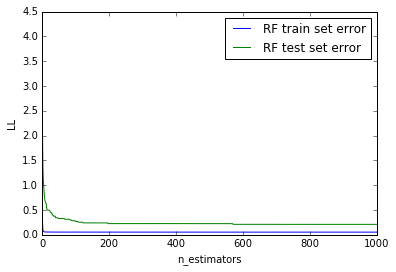

In [30]:
n_estimators = 1000
plot_score_graph(RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', max_features=330, n_jobs=-1),
               X_train[:, :330], X_test[:, :330], y_train, y_test,
               prefix='RF')

In [25]:
from sklearn.grid_search import GridSearchCV

In [31]:
clf = RandomForestClassifier(n_estimators=2000, criterion='entropy', max_features=330, n_jobs=-1)
clf.fit(Xtrain[:, :330], ytrain)

ypred = clf.predict_proba(Xtest[:, :330])[:, 1]

Попробуем разобраться с генетической информацией

In [32]:
def encode(X):
    X_gene = (2 * X[:, 330:]).astype(int)
    X_dummy = np.zeros((X.shape[0],3000))
    for i in range(X.shape[0]):
        for j in range(1000):
            X_dummy[i, j * 3 + X_gene[i, j]] = 1
    return np.hstack((X[:, :330], X_dummy))

In [33]:
X_train_encoded = encode(Xtrain)
X_test_encoded = encode(Xtest)

In [34]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_train_encoded, ytrain, test_size=0.5)

1.71937607073
0.0576449905049
0.0569941282318
0.0566617010902
0.0566688456062
0.0565822138087
0.056392773766
0.0564347602567
0.0564601557884
0.0564376977301
4.81864955009
0.212938325762
0.212599969787
0.21129669493
0.21122902006
0.211380166684
0.211111142504
0.210841527006
0.210763713015
0.210476793526


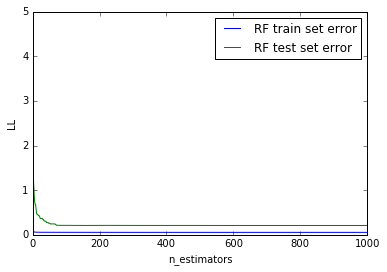

In [35]:
n_estimators = 1000
plot_score_graph(RandomForestClassifier(n_estimators=n_estimators, criterion='entropy', max_features=400, n_jobs=-1),
               X_train, X_test, y_train, y_test,
               prefix='RF')

In [40]:
from sklearn.svm import SVC

class ProbSVC(SVC):
    def predict(self, X):
        return super(ProbSVC, self).predict_proba(X)

In [41]:
def learn(clf, params, X, y):
    grid_searcher = GridSearchCV(clf,\
                             params, cv=3, scoring='log_loss', n_jobs=-1)
    grid_searcher.fit(X, y)

    print(grid_searcher.best_score_)
    print(grid_searcher.best_estimator_)
    
    return grid_searcher

In [44]:
from sklearn.preprocessing import scale

X_train_scaled = scale(X_train_encoded)
X_test_scaled = scale(X_test_encoded)

In [53]:
%%time

params = {'gamma': ['auto', 1/4000, 1/3000, 1/2000, 1/1000, 1/500]}
svc_searcher = learn(ProbSVC(kernel='rbf', C=0.1, class_weight='balanced', probability=True, cache_size=600),\
                     params, X_train_scaled, ytrain)

-0.229025017316
ProbSVC(C=0.1, cache_size=600, class_weight='balanced', coef0=0.0,
    decision_function_shape=None, degree=3, gamma=0.00025, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
CPU times: user 5min 48s, sys: 1.21 s, total: 5min 49s
Wall time: 41min 53s


Смешаем SVC и RFC

In [ ]:
from sklearn.ensemble import VotingClassifier as VC

In [ ]:
rfc_est = RandomForestClassifier(n_estimators=2000, criterion='entropy', max_features=400, n_jobs=-1)
svc_est = svc_searcher.best_estimator_

mix_clf = VC(estimators=[('rfc', rfc_est), ('svc', svc_est)], voting='soft')

In [ ]:
params = {'weights': [[alpha, 1 - alpha] for alpha in arange(0.1, 1.0, 0.1)]}
mix_searcher = learn(mix_clf, params, X_train_scaled, ytrain)

In [ ]:
clf = mix_searcher.best_estimator_
clf.fit(X_train_scaled, ytrain)

ypred = clf.predict_proba(X_test_scaled)[:, 1]

# Save predictions

In [133]:
dfpred = pd.DataFrame()
dfpred['Id'] = np.arange(len(ypred))
dfpred['Prediction'] = ypred

dfpred.to_csv('y.predicted.csv', index = False)